# ML Classifier Copies - Image Segmentation Model Example

An example where we take an existing "black box" classifier model of the publicly available [Image Segmentation dataset](https://archive-beta.ics.uci.edu/ml/datasets/Image+Segmentation), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.sampling import grid_sampling, normal_sampling, spherical_balancer_sampling, labeling
from ML_copies_original_models import WinesModel, OccupancyModel, SegmentationModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

In [4]:
segmentation_model = SegmentationModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [21]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression(max_iter=1000))])
knn_normal_classifier = Pipeline([('scaler', StandardScaler()), ('KKN_classifier', 
                                KNeighborsClassifier(n_neighbors=30, weights="distance"))])
tree_normal_classifier = DecisionTreeClassifier()

We will assume that we don't know anything about the distribution of the numerical features, but that we can normalize them as a pre-processing step before training the model and thus force them to be centered at 0 and have a standard deviation of 1.

In [19]:
feature_description = segmentation_model.feature_description

In [18]:
balance_parameters={"max_iter": 50, "nbatch": 1500, "verbose": False}
log_normal_copy = ClassifierCopy(segmentation_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=20000, random_state=42,
                                 feature_parameters=feature_description, label_col="class",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

knn_normal_copy = ClassifierCopy(segmentation_model.model, knn_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=20000, random_state=42,
                                  feature_parameters=feature_description, label_col="class",
                                  **balance_parameters) 
knn_normal_copy_training_data = knn_normal_copy.copy_classifier(get_training_data=True)

tree_normal_copy = ClassifierCopy(segmentation_model.model, tree_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=20000, random_state=42,
                                 feature_parameters=feature_description, label_col="class",
                                 **balance_parameters) 
tree_normal_copy_training_data = tree_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [20]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                segmentation_model.X_test.join(segmentation_model.y_test), label_col="class"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * KNN copy:")
synthetic_knn_normal_test_data = knn_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_knn_normal_copy = knn_normal_copy.evaluation_summary(test_data=Dataset(
                                                segmentation_model.X_test.join(segmentation_model.y_test), label_col="class"), 
                                                                  synthetic_data=synthetic_knn_normal_test_data)

print("\n * Decision tree copy:")
synthetic_tree_normal_test_data = tree_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_tree_normal_copy = tree_normal_copy.evaluation_summary(test_data=Dataset(
                                                segmentation_model.X_test.join(segmentation_model.y_test), label_col="class"), 
                                                                  synthetic_data=synthetic_tree_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9500
Copy Model Accuracy (test)              0.7655
Empirical Fidelity Error (synthetic)    0.2555
Empirical Fidelity Error (test)         0.2167
Replacement Capability (synthetic)      0.7445
Replacement Capability (test)           0.8058

 * KNN copy:
Original Model Accuracy (test)          0.9500
Copy Model Accuracy (test)              0.7202
Empirical Fidelity Error (synthetic)    0.3265
Empirical Fidelity Error (test)         0.2655
Replacement Capability (synthetic)      0.6735
Replacement Capability (test)           0.7581

 * Decision tree copy:
Original Model Accuracy (test)          0.9500
Copy Model Accuracy (test)              0.3679
Empirical Fidelity Error (synthetic)    0.4705
Empirical Fidelity Error (test)         0.6298
Replacement Capability (synthetic)      0.5295
Replacement Capability (test)           0.3872


[Index](#Index)  
  
  


<a name="Boundaries">  


### Decision boundaries

#### Original model

In [23]:
visualization_data = normal_sampling(nsamples=1000000, feature_parameters=feature_description)
visualization_original = labeling(visualization_data, segmentation_model.model, label_col="class")

In [24]:
visualization_original.df["class"].value_counts()

CEMENT       388859
FOLIAGE      224175
WINDOW       165827
PATH         111608
BRICKFACE     97128
GRASS         12349
SKY              54
Name: class, dtype: int64

In [49]:
colors = {"CEMENT":"#8787ff", "FOLIAGE":"#ff8e8e", "WINDOW":"#a6ffa6", "PATH":"#939393", "BRICKFACE":"#d37788", 
          "GRASS":"#a6ffc3", "SKY":"#c4faff"}

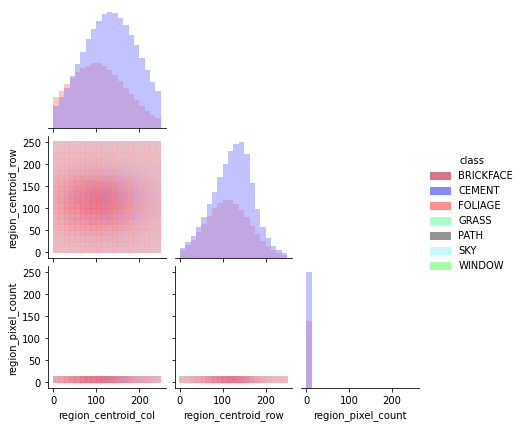

In [50]:
max_nfeatures = len(visualization_original.feature_names[0:3])
g = sns.pairplot(visualization_original.df[visualization_original.df["class"].isin(["CEMENT", "FOLIAGE"])], 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 250, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 250, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

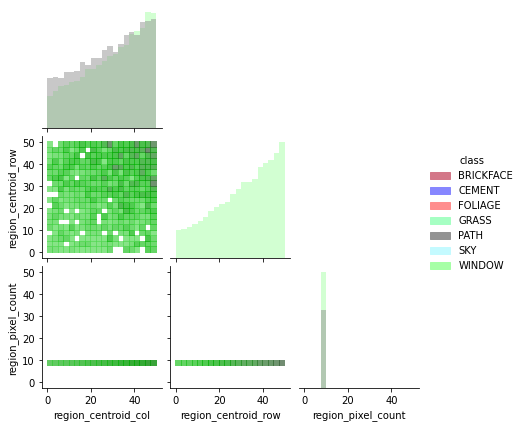

In [51]:
g = sns.pairplot(visualization_original.df[visualization_original.df["class"].isin(["WINDOW", "PATH"])], 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 50, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 50, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

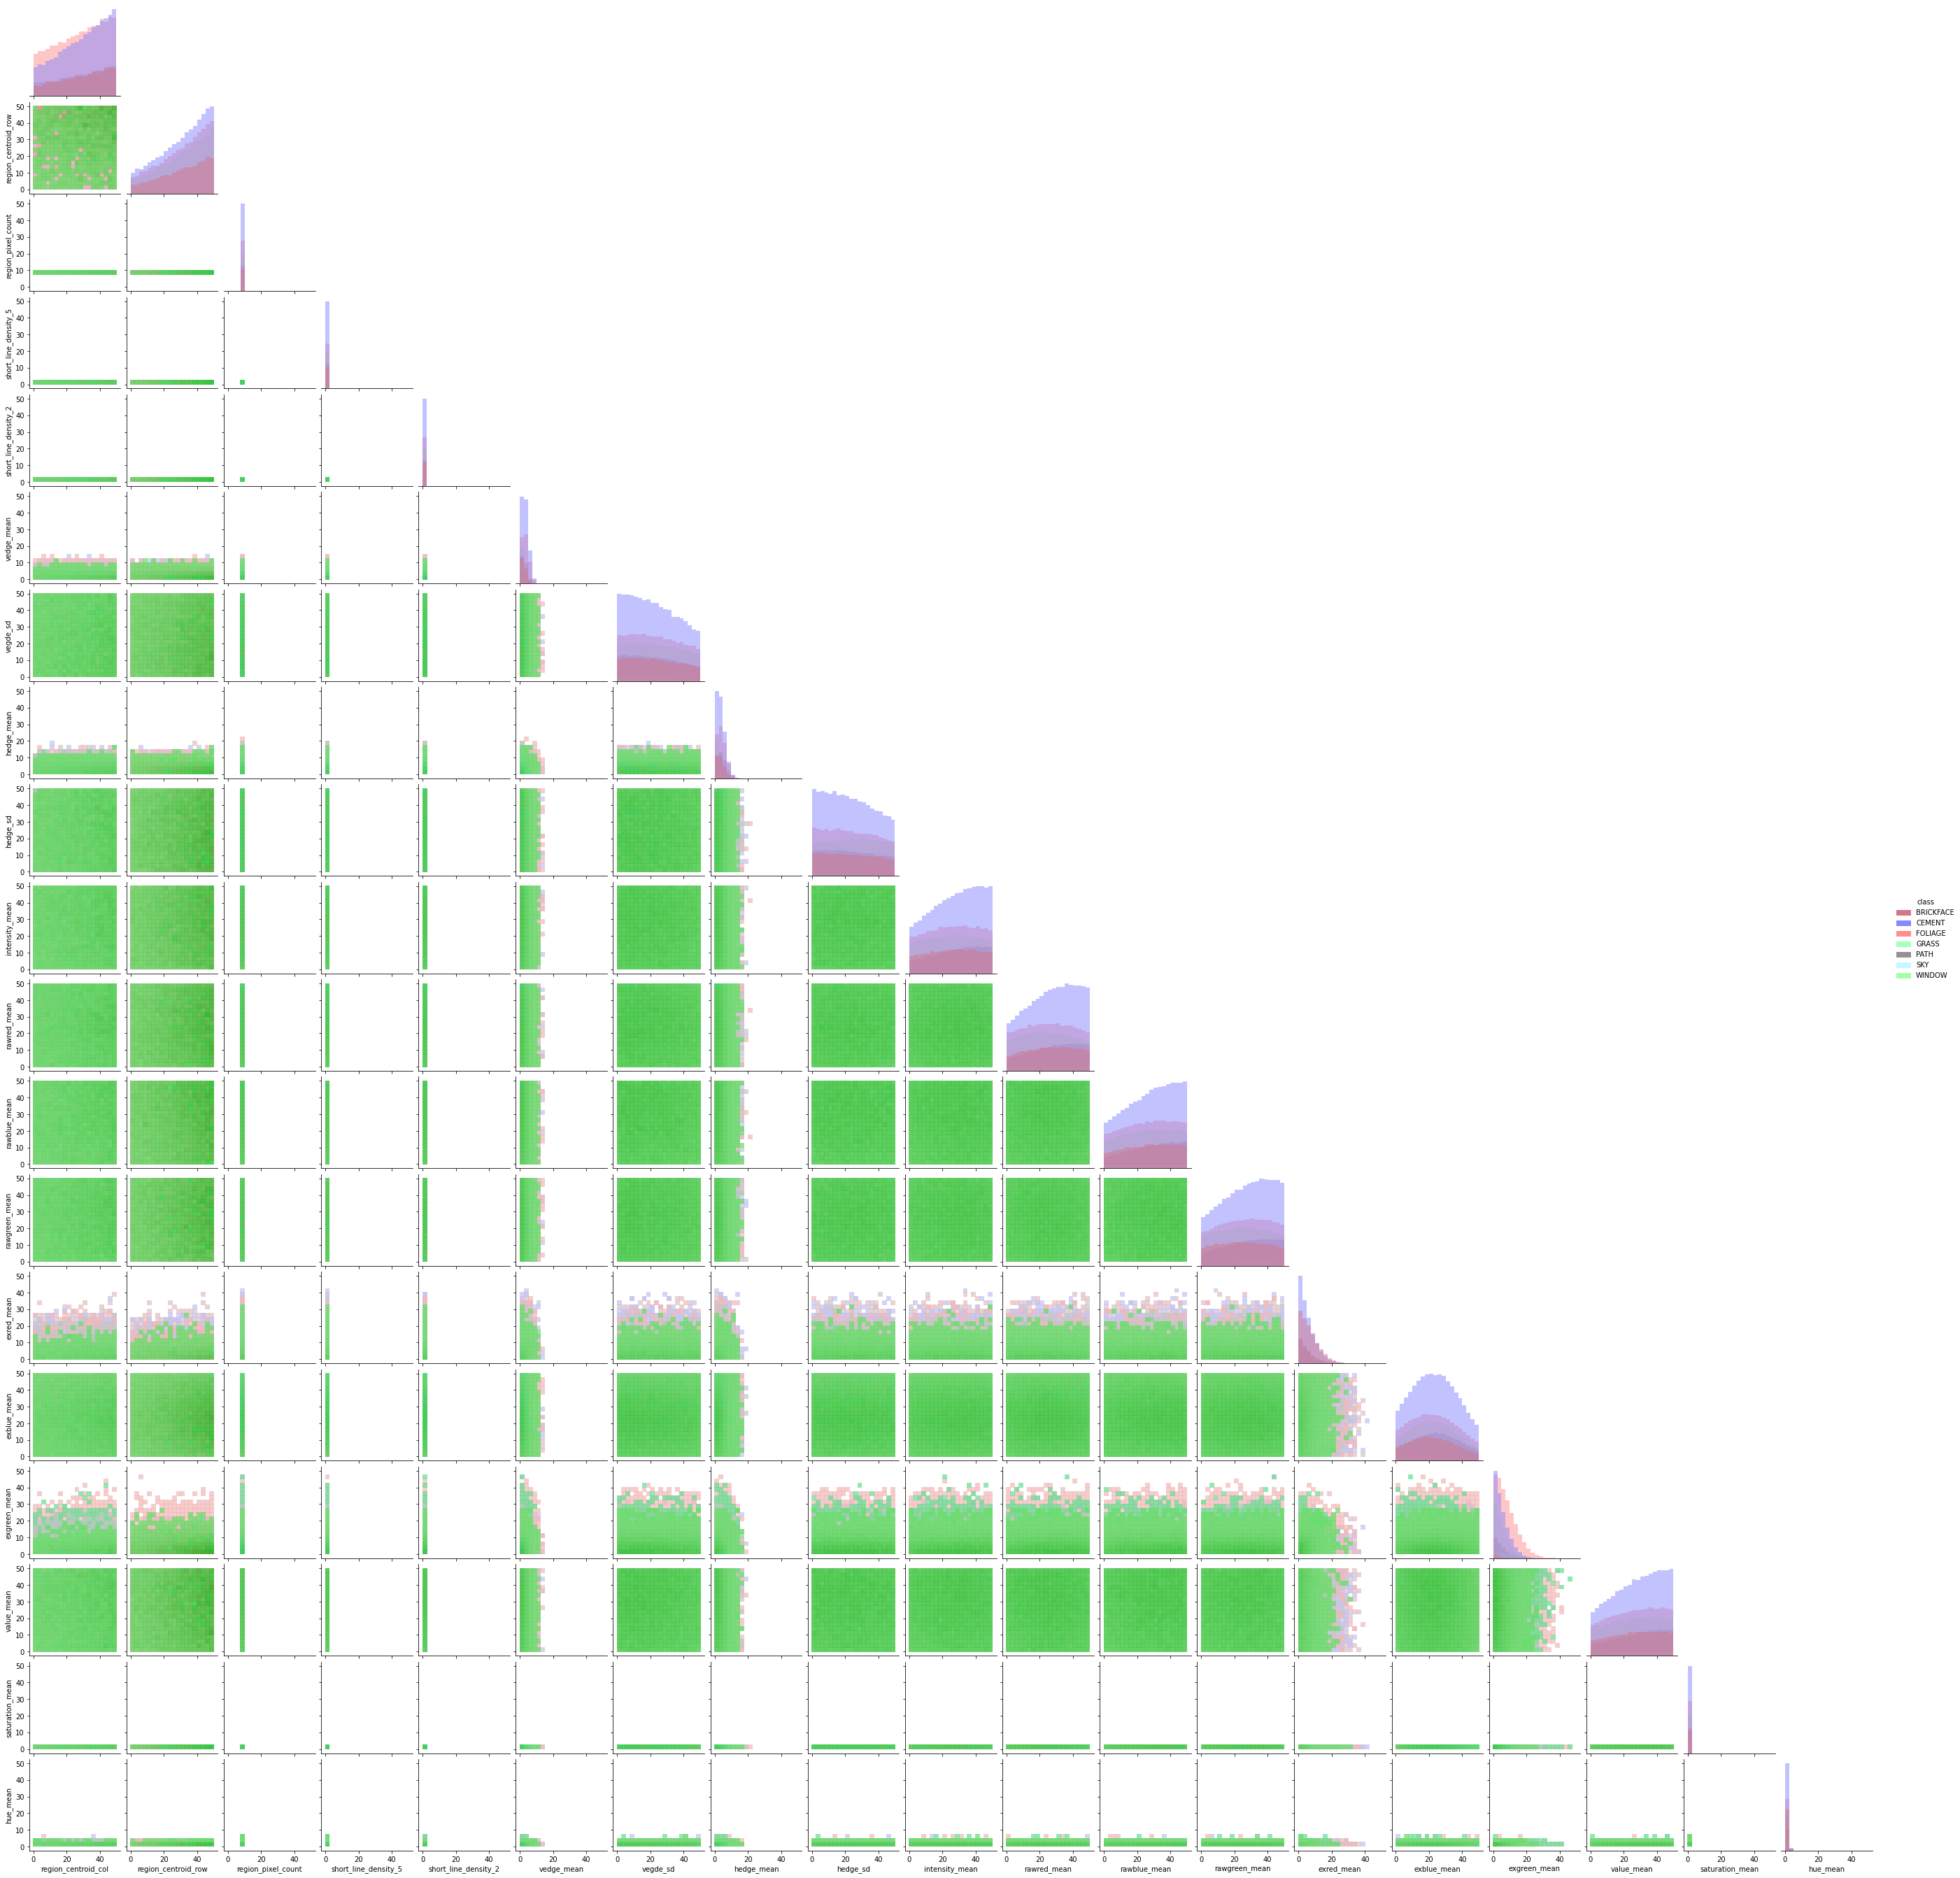

In [52]:
max_nfeatures = len(visualization_original.feature_names)
g = sns.pairplot(visualization_original.df, 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 50, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 50, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

-----
-----

[Index](#Index)  
  
  

----